In [1]:
import pandas as pd
import gzip
import matplotlib.ticker as ticker # used for setting custom xticks
from matplotlib.dates import DateFormatter # used for formatting x value dates
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np
from collections import Counter 
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from wordcloud import WordCloud #This is a complicated import, please disregard if the images from report are enough
sns.set_style("darkgrid") # Use seaborn styling for ALL graphs
sns.set_color_codes() # change colour code to more pleasant scheme 
sns.set(font_scale=1.5, font="Verdana") # set font size and font style for ALL graphs 

# Data Preparation and Processing

Some text about it

In [2]:
df = pd.read_json('Automotive_5.json', lines=True)
df.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


Let's get some info about the dataset

In [3]:
print("Total number of reviews: {0}\n".format(len(df)))
print(df.info())
print("\n\nNull check: \n{0}\n\n".format(df.isnull().sum()))
print("Shape: {0}\n".format(df.shape))
print("Descriptive statistics: \n",df.describe())

# Find how positive/negative/neutral reviews are
print("\nPercent of Positive Reviews: {:.1f}%\n".format(df[df['overall'] > 3]["reviewText"].count() / len(df)*100))
print("Percent of Negative Reviews: {:.1f}%\n".format(df[df['overall'] < 3]["reviewText"].count() / len(df)*100))
print("Percent of Neural Reviews: {:.1f}%\n".format(df[df['overall'] == 3]["reviewText"].count() / len(df)*100))

Total number of reviews: 20473

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20473 entries, 0 to 20472
Data columns (total 9 columns):
asin              20473 non-null object
helpful           20473 non-null object
overall           20473 non-null int64
reviewText        20473 non-null object
reviewTime        20473 non-null object
reviewerID        20473 non-null object
reviewerName      20260 non-null object
summary           20473 non-null object
unixReviewTime    20473 non-null int64
dtypes: int64(2), object(7)
memory usage: 1.4+ MB
None


Null check: 
asin                0
helpful             0
overall             0
reviewText          0
reviewTime          0
reviewerID          0
reviewerName      213
summary             0
unixReviewTime      0
dtype: int64


Shape: (20473, 9)

Descriptive statistics: 
             overall  unixReviewTime
count  20473.000000    2.047300e+04
mean       4.471841    1.365018e+09
std        0.940337    3.621266e+07
min        1.000000    1.12138

Replace all na/nan values within reviewer name with 'Amazon Customer'

In [4]:
df.fillna('Amazon Customer', inplace=True)
# Double check to see if any nan values remain
df.isnull().sum()

asin              0
helpful           0
overall           0
reviewText        0
reviewTime        0
reviewerID        0
reviewerName      0
summary           0
unixReviewTime    0
dtype: int64

Convert all review times to datetime datatype (initially an object) 

In [5]:
df.reviewTime = pd.to_datetime(df.reviewTime, errors='coerce')

Remove Unixtime column

In [6]:
del df['unixReviewTime']

Load Product Dataset

In [7]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

productdf = getDF('meta_Automotive.json.gz')

Let's get some information about the product dataset

In [8]:
print(productdf.info())
print("\n\nNull check: \n{0}\n\n".format(productdf.isnull().sum()))
print("Shape: {0}\n".format(productdf.shape))
print("Descriptive statistics: \n",productdf.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331090 entries, 0 to 331089
Data columns (total 9 columns):
asin           331090 non-null object
categories     331090 non-null object
description    311609 non-null object
title          326656 non-null object
price          282569 non-null float64
imUrl          330751 non-null object
brand          186621 non-null object
related        247100 non-null object
salesRank      16920 non-null object
dtypes: float64(1), object(8)
memory usage: 25.3+ MB
None


Null check: 
asin                0
categories          0
description     19481
title            4434
price           48521
imUrl             339
brand          144469
related         83990
salesRank      314170
dtype: int64


Shape: (331090, 9)

Descriptive statistics: 
                price
count  282569.000000
mean       73.796909
std       105.147722
min         0.010000
25%        15.050000
50%        36.860000
75%        86.520000
max       999.990000


Filling in NaN values with braces/empty value

In [9]:
# Fill empty values with empty braces
productdf['salesRank'].fillna(value='{}', inplace=True)
productdf['related'].fillna(value='{}', inplace=True)
productdf['description'].fillna(value='', inplace=True)

Deleting the imUrl column, not useful for this analysis

In [10]:
del productdf['imUrl']

Now let's analyse the product dataset

In [11]:
products = df['overall'].groupby(df['asin']).count()
print("\nNumber of Unique Products in Electronics = {}".format(products.count()))


Number of Unique Products in Electronics = 1835


What are the most reviewed products?

In [12]:
sort_products = products.sort_values(ascending=False)
print("Top 25 Reviewed Products:\n")
print(sort_products[:25])

Top 25 Reviewed Products:

asin
B000CITK8S    169
B007TG7HFO    118
B001V8U12M    111
B002BC4N5I     90
B002OUMVWY     82
B00068XCQU     79
B0014Y82UQ     79
B000NCOKZQ     79
B0009IQZFM     79
B001LHVOVK     77
B005NLQAHS     73
B001GJ3DZS     71
B000AA4RWM     71
B0009IQZH0     69
B000RXKR6M     66
B000XECJES     66
B00B7GC50Y     66
B000M5UD1E     65
B00080QHMM     64
B000FW2MWW     62
B008FYKOX6     62
B001AIZ5HY     62
B000N3W8J0     60
B000BYB2J8     60
B0041CDPQO     58
Name: overall, dtype: int64


The top reviewed product at 169 reviews is for a Battery charger (B000CITK8S)

This is followed by a Wiper blade (B007TG7HFO) at 118 reviews and a Jack Socket Drill Adapter (B001V8U12M) at 111 reviews

In [13]:
length = len(sort_products)
length = length - 25
print("Least 25 Reviewed Products:\n")
print(sort_products[length:])

Least 25 Reviewed Products:

asin
B007H8DKJG    5
B007G7PUMS    5
B004RCUTFI    5
B0041CAC4W    5
B000AP57OO    5
B002M1SQ24    5
B000AP8EQ2    5
B000ARPVOI    5
B0030D0T2S    5
B000AS1XYE    5
B007ECFURK    5
B001EP28DC    5
B007CVSBL0    5
B007BSG760    5
B001F85OUM    5
B000GZAUQ8    5
B000GU5IUQ    5
B007B8JMZI    5
B007B86Z94    5
B004SRRELY    5
B002L146OC    5
B000GU24N0    5
B0033A5OQO    5
B002VVIC06    5
B0043GCVUY    5
Name: overall, dtype: int64


What is the most common amount of reviews on Automotive products? And what is the average price of Automotive products?

In [14]:
print('Most common amount of reviews for Electronic: {}'.format(products.mode()))
av_price = productdf['price'].mean()
print("Average price of product: ${:.2f}".format(av_price))

Most common amount of reviews for Electronic: 0    5
dtype: int64
Average price of product: $73.80


Products mostly have 5 reviews associated with them

# Data Visualization

Moving onto visualizing this data. The first thing is to see how many submissions occured over the years  

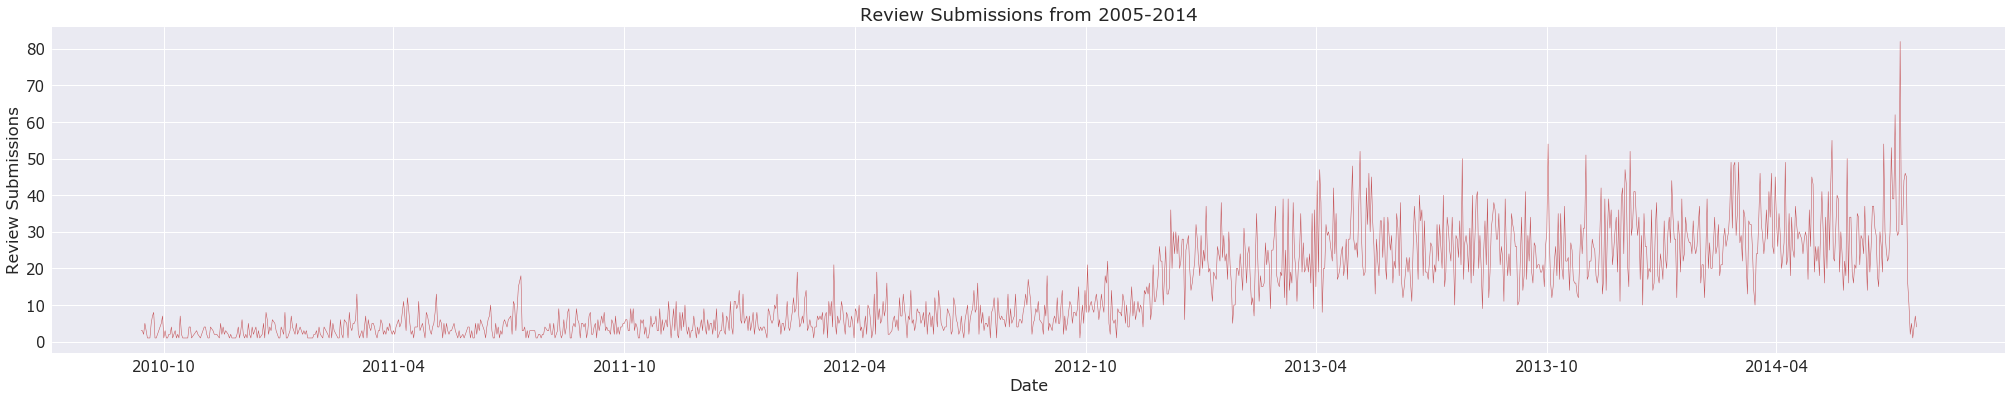

In [15]:
new_df = df
new_df.sort_values(['reviewTime'],inplace=True)
year_counts=new_df['reviewTime'].value_counts()
year_counts=year_counts.to_frame().reset_index()
year_counts=year_counts.sort_values('index')
fig=plt.subplots(figsize=(35,6))
plt.plot(year_counts['index'][500:],year_counts['reviewTime'][500:],'r-',linewidth=0.5)
plt.xlabel('Date')
plt.ylabel('Review Submissions')
plt.title('Review Submissions from 2005-2014')
plt.show()

In [16]:
dates = new_df.reviewTime
a = dates.dt.strftime('%d-%m-%Y')

In [17]:
final_df = new_df.merge(productdf, on="asin")
print(type(final_df))
x = final_df.groupby(final_df.reviewTime.dt.year).describe()
x 

<class 'pandas.core.frame.DataFrame'>


overall                                                price  \
             count      mean       std  min  25%  50%  75%  max   count   
reviewTime                                                                
2005           3.0  4.666667  0.577350  4.0  4.5  5.0  5.0  5.0     3.0   
2006          11.0  4.363636  1.286291  1.0  4.5  5.0  5.0  5.0    10.0   
2007          45.0  4.688889  0.733058  2.0  5.0  5.0  5.0  5.0    41.0   
2008         118.0  4.457627  1.051203  1.0  4.0  5.0  5.0  5.0   115.0   
2009         307.0  4.439739  0.966151  1.0  4.0  5.0  5.0  5.0   298.0   
2010         662.0  4.380665  1.006839  1.0  4.0  5.0  5.0  5.0   636.0   
2011        1397.0  4.468146  0.955992  1.0  4.0  5.0  5.0  5.0  1343.0   
2012        3148.0  4.437421  1.000901  1.0  4.0  5.0  5.0  5.0  3081.0   
2013        9022.0  4.471957  0.923790  1.0  4.0  5.0  5.0  5.0  8901.0   
2014        5760.0  4.502257  0.915986  1.0  4.0  5.0  5.0  5.0  5694.0   

                                                                          
                 mean        std    min      25%    50%      75%     max  
reviewTime                                                                
2005        62.323333  40.961582  19.22  43.1150  67.01  83.8750  100.74  
2006        19.750000  24.323139   4.59   5.5525   8.04  21.5975   80.45  
2007        28.187073  26.807524   4.29  10.0900  17.29  39.9800  146.99  
2008        29.631739  34.930089   3.99  10.4650  15.17  35.0750  159.95  
2009        23.699262  32.509657   1.95   9.9900  13.01  23.5900  293.10  
2010        28.784623  39.501699   0.01   9.4100  15.99  30.0300  326.80  
2011        29.031310  47.443576   0.37   9.0450  14.99  30.5000  975.00  
2012        27.303901  49.882178   0.01   8.9900  14.99  26.9900  975.00  
2013        26.607217  40.269731   0.01   8.9900  14.49  27.2000  975.00  
2014        24.528151  37.607178   0.01   8.6800  13.99  25.9900  975.00

This can be summarised further by grabbing just the monthly values

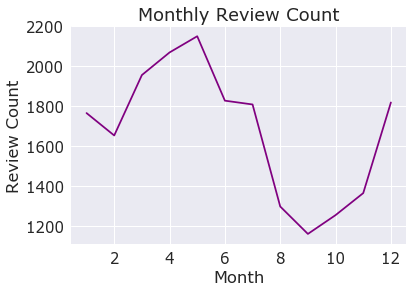

In [18]:
z = final_df.groupby(final_df.reviewTime.dt.month).count()
plt.plot(z.price, 'purple')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("Monthly Review Count")
plt.show()

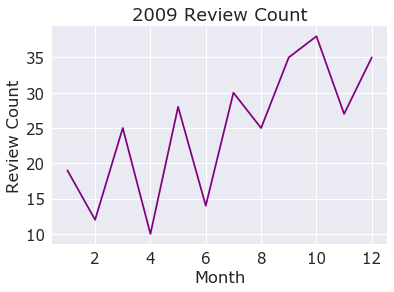

In [19]:
testdf = final_df.loc[final_df.reviewTime.dt.year == 2009]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'purple')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("2009 Review Count")
plt.show()

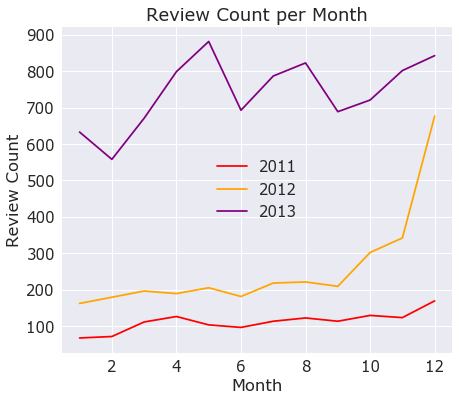

In [20]:
fig=plt.subplots(figsize=(7,6))

#Insignificant (low count) data
# testdf = final_df.loc[final_df.reviewTime.dt.year == 2009]
# z = testdf.groupby(testdf.reviewTime.dt.month).count()
# plt.plot(z.price, 'blue',label="2009")

# testdf = final_df.loc[final_df.reviewTime.dt.year == 2010]
# z = testdf.groupby(testdf.reviewTime.dt.month).count()
# plt.plot(z.price, 'green',label="2010")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'red',label="2011")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'orange',label="2012")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'purple', label="2013")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("Review Count per Month")
plt.show()

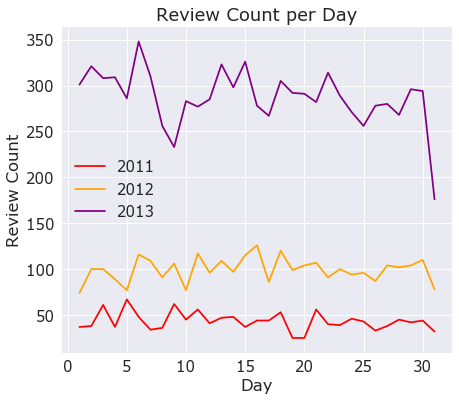

In [21]:
fig=plt.subplots(figsize=(7,6))

# testdf = final_df.loc[final_df.reviewTime.dt.year == 2009]
# z = testdf.groupby(testdf.reviewTime.dt.day).count()
# plt.plot(z.price, 'blue',label="2009")

# testdf = final_df.loc[final_df.reviewTime.dt.year == 2010]
# z = testdf.groupby(testdf.reviewTime.dt.day).count()
# plt.plot(z.price, 'green',label="2010")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.day).count()
plt.plot(z.price, 'red',label="2011")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.day).count()
plt.plot(z.price, 'orange',label="2012")

testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.day).count()
plt.plot(z.price, 'purple', label="2013")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Review Count")
plt.title("Review Count per Day")
plt.show()

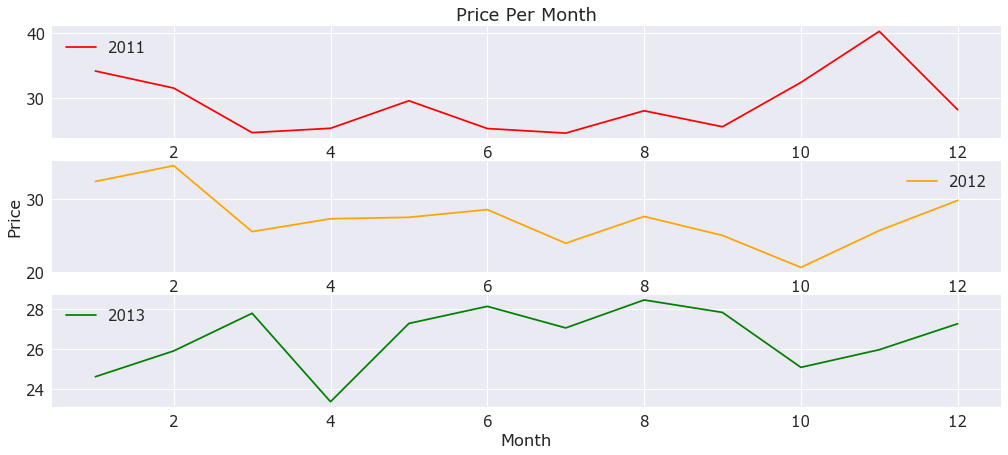

In [22]:
fig=plt.subplots(figsize=(17,7))

plt.subplot(3,1,1)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.price, 'red',label="2011")
plt.legend()
plt.title("Price Per Month")
plt.subplot(3,1,2)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.price, 'orange',label="2012")
plt.legend()
plt.ylabel("Price")
plt.subplot(3,1,3)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.price, 'green', label="2013")

plt.legend()
plt.xlabel("Month")

plt.show()

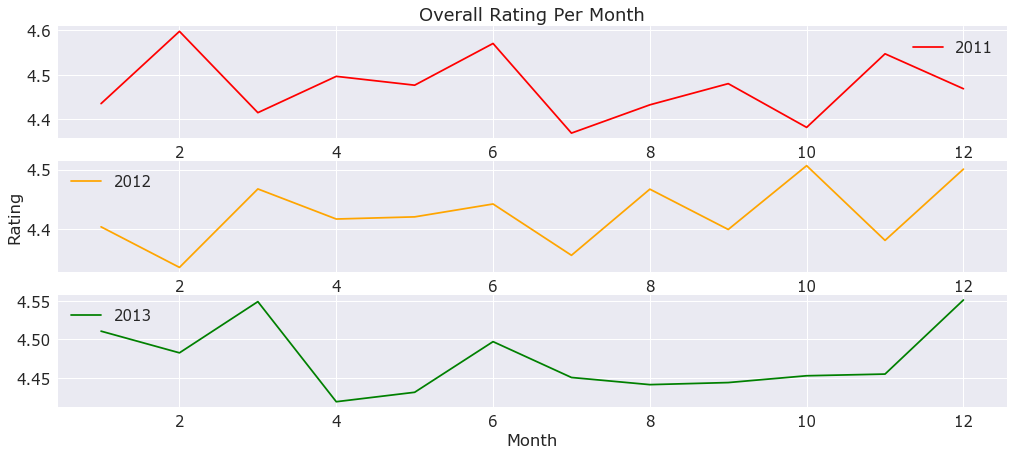

In [23]:
fig=plt.subplots(figsize=(17,7))

plt.subplot(3,1,1)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.overall, 'red',label="2011")
plt.legend()
plt.title("Overall Rating Per Month")
plt.subplot(3,1,2)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.overall, 'orange',label="2012")
plt.legend()
plt.ylabel("Rating")
plt.subplot(3,1,3)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.month).mean()
plt.plot(z.overall, 'green', label="2013")

plt.legend()
plt.xlabel("Month")

plt.show()

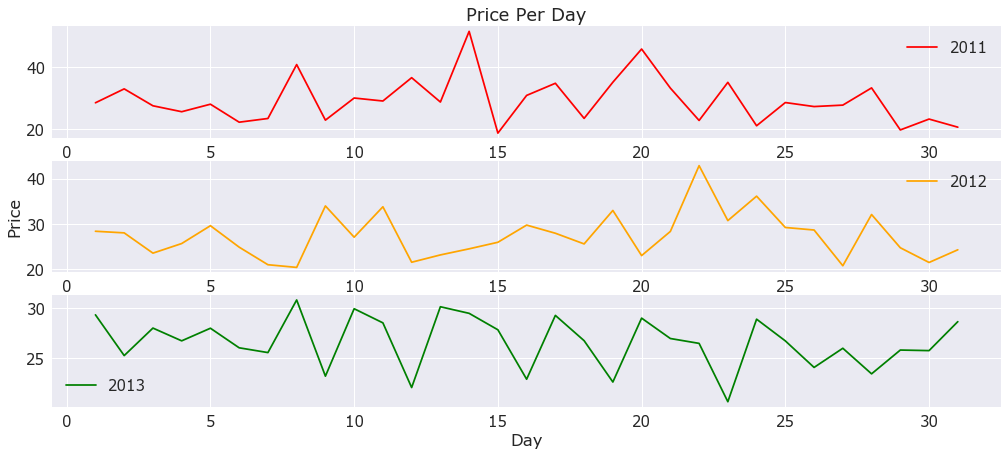

In [24]:
fig=plt.subplots(figsize=(17,7))

plt.subplot(3,1,1)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.price, 'red',label="2011")
plt.legend()
plt.title("Price Per Day")
plt.subplot(3,1,2)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.price, 'orange',label="2012")
plt.legend()
plt.ylabel("Price")
plt.subplot(3,1,3)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.price, 'green', label="2013")

plt.legend()
plt.xlabel("Day")

plt.show()

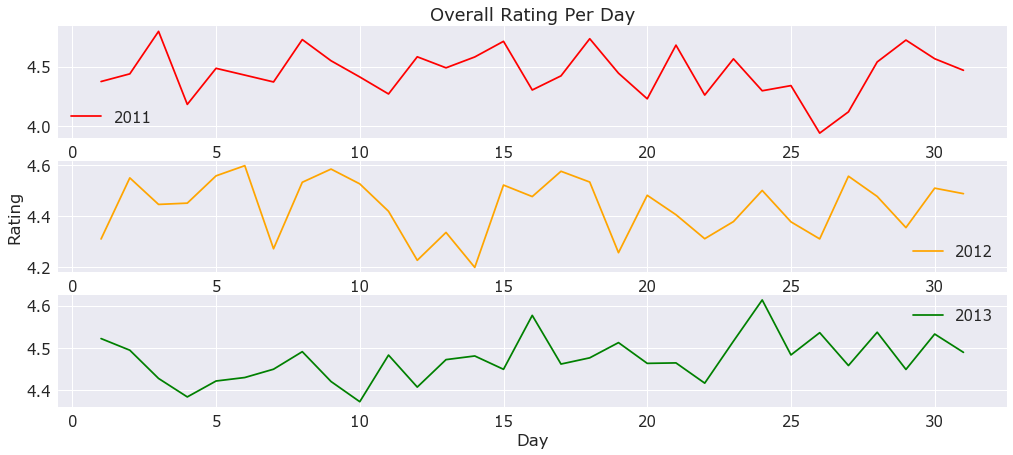

In [25]:
fig=plt.subplots(figsize=(17,7))
plt.xlabel("Day")
plt.ylabel("Rating?")
plt.title("Overall Rating Per Day")
plt.subplot(3,1,1)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.overall, 'red',label="2011")
plt.title("Overall Rating Per Day")
plt.legend()
plt.subplot(3,1,2)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.overall, 'orange',label="2012")
plt.ylabel("Rating")
plt.legend()
plt.subplot(3,1,3)
testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.day).mean()
plt.plot(z.overall, 'green', label="2013")
plt.xlabel("Day")
plt.legend()

plt.show()

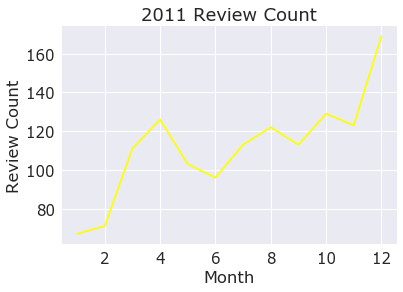

In [26]:
testdf = final_df.loc[final_df.reviewTime.dt.year == 2011]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'yellow')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("2011 Review Count")
plt.show()

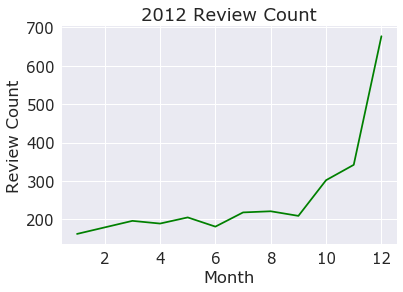

In [27]:
testdf = final_df.loc[final_df.reviewTime.dt.year == 2012]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'green')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("2012 Review Count")
plt.show()

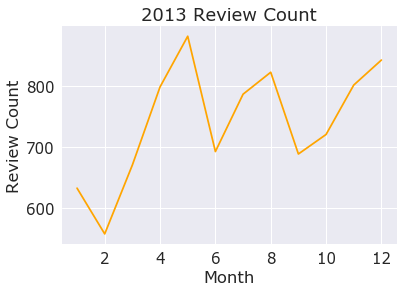

In [28]:
testdf = final_df.loc[final_df.reviewTime.dt.year == 2013]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'orange')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("2013 Review Count")
plt.show()

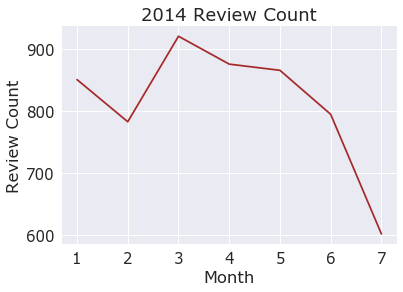

In [29]:
testdf = final_df.loc[final_df.reviewTime.dt.year == 2014]
z = testdf.groupby(testdf.reviewTime.dt.month).count()
plt.plot(z.price, 'brown')
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.title("2014 Review Count")
plt.show()

In [30]:
final_df = new_df.merge(productdf, on="asin")
print(type(final_df))
x = final_df.groupby(final_df.reviewTime.dt.year).describe()

temp = final_df.groupby([final_df.reviewTime.dt.month, final_df.reviewTime.dt.day]).mean()
average_price = pd.concat([temp.price[1], temp.price[2], temp.price[3], temp.price[4], 
                 temp.price[5], temp.price[6], temp.price[7], temp.price[8], 
                 temp.price[9], temp.price[10], temp.price[11], temp.price[12]])
average_price_final = pd.DataFrame(average_price)
average_price_final.reset_index(inplace=True)
average_price_final['day'] = average_price_final.index

<class 'pandas.core.frame.DataFrame'>


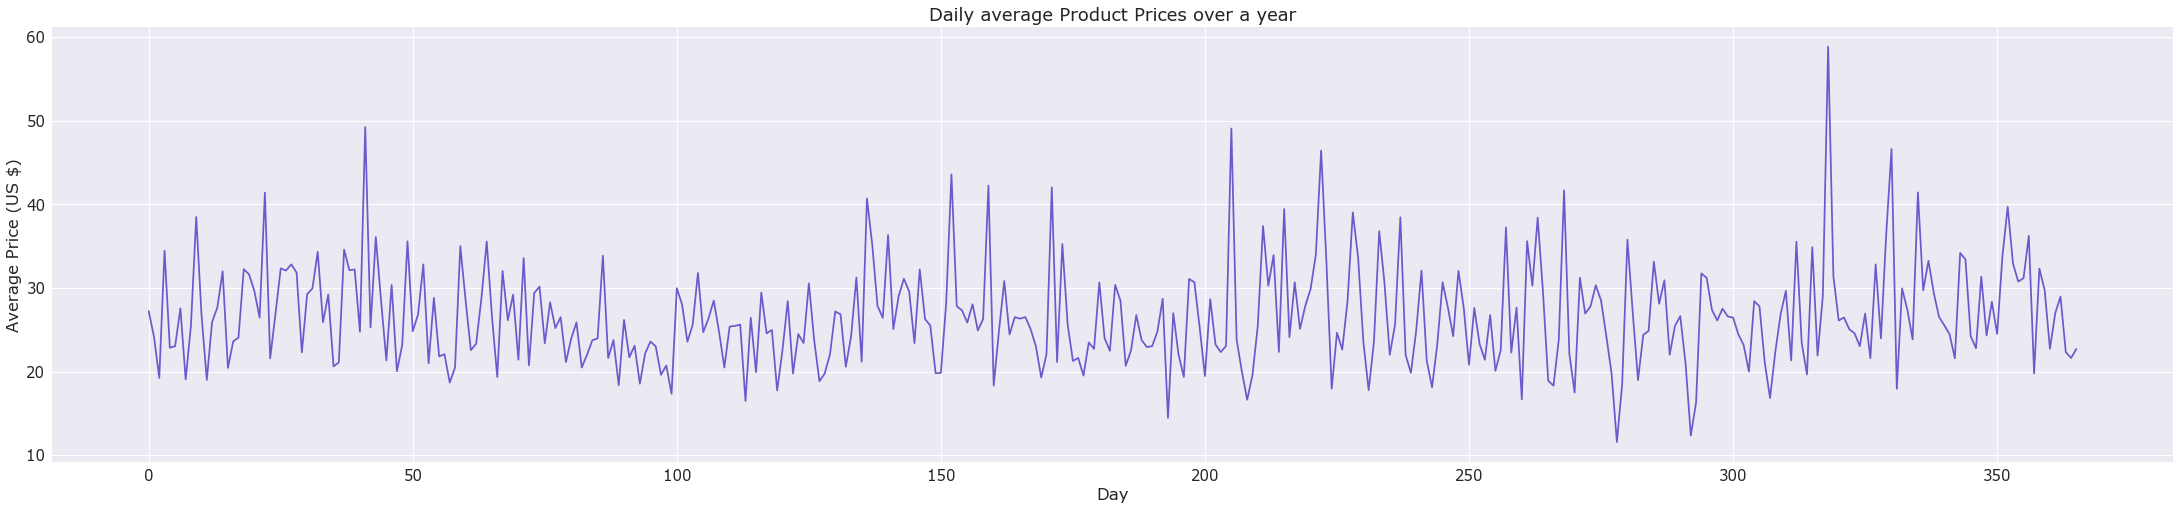

In [31]:
fig, ax = plt.subplots(figsize=(38,8))
plt.plot(average_price_final.price, c='slateblue')
plt.xlabel('Day')
plt.ylabel('Average Price (US $)')
plt.title('Daily average Product Prices over a year')
plt.show()

The same can be done for average overall ratings

In [32]:
average_rating = pd.concat([temp.overall[1], temp.overall[2], temp.overall[3], temp.overall[4], 
                 temp.overall[5], temp.overall[6], temp.overall[7], temp.overall[8], 
                 temp.overall[9], temp.overall[10], temp.overall[11], temp.overall[12]])
average_rating_final = pd.DataFrame(average_rating)
average_rating_final.reset_index(inplace=True)
average_rating_final['day'] = average_rating_final.index

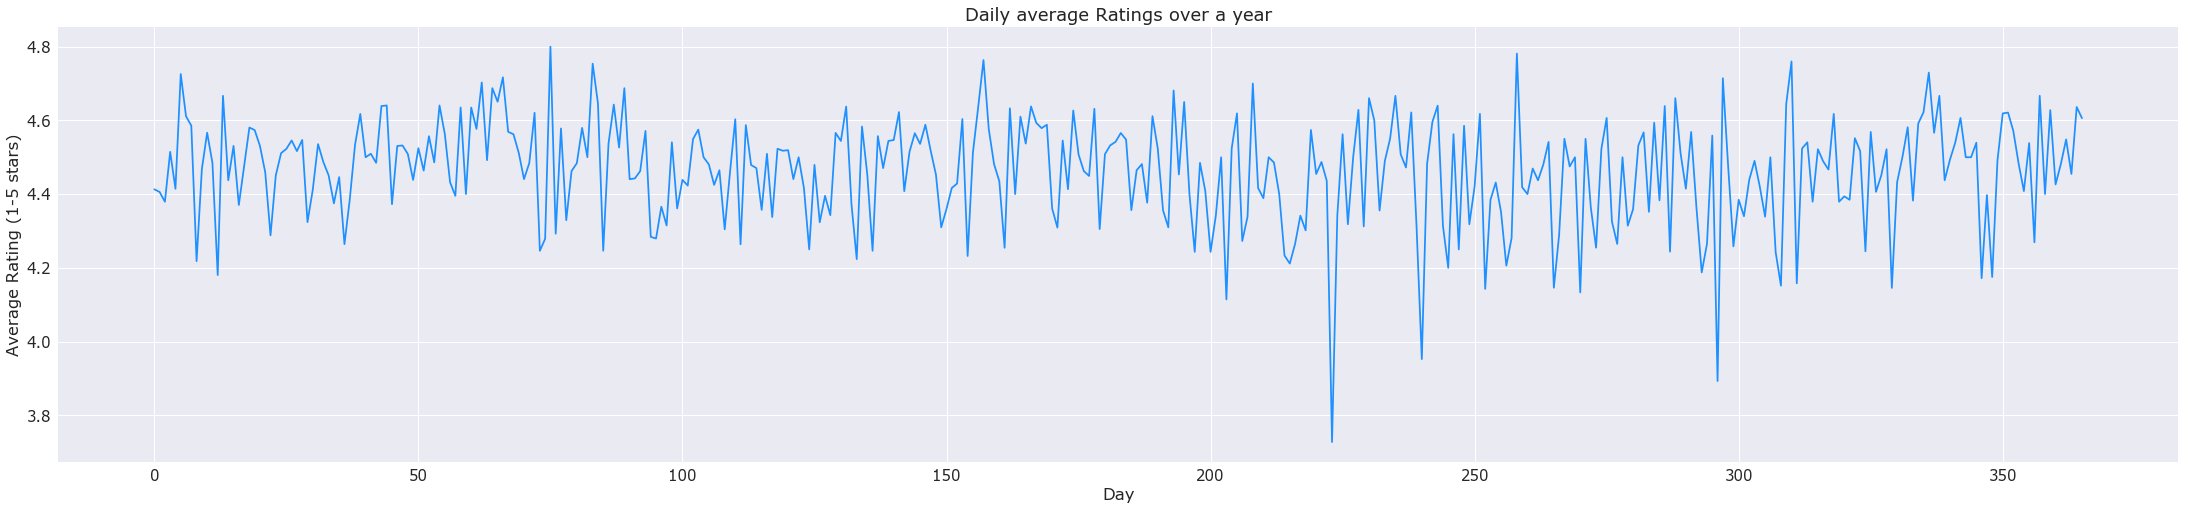

In [33]:
fig, ax = plt.subplots(figsize=(38,8))
plt.plot(average_rating_final.overall, c='dodgerblue')
plt.xlabel('Day')
plt.ylabel('Average Rating (1-5 stars)')
plt.title('Daily average Ratings over a year')
plt.show()

We can generalise this by looking at it in Years and Months

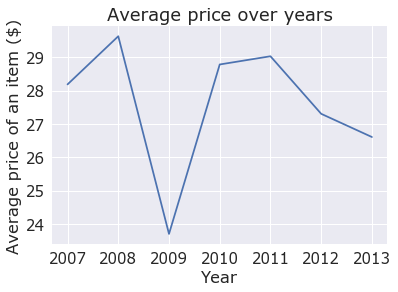

In [34]:
z = final_df.groupby(final_df.reviewTime.dt.year).mean()
z.price
plt.plot(z.price[2:-1])
plt.xlabel("Year")
plt.ylabel("Average price of an item ($)")
plt.title("Average price over years")
plt.show()

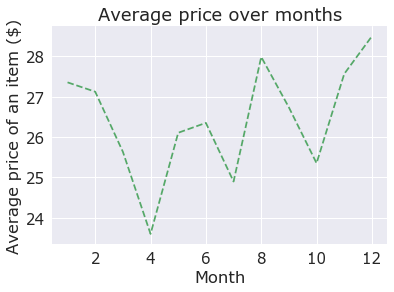

In [35]:
z = final_df.groupby(final_df.reviewTime.dt.month).mean()
z.price
plt.plot(z.price, 'g--')
plt.xlabel("Month")
plt.ylabel("Average price of an item ($)")
plt.title("Average price over months")
plt.show()

A peak in August is found. Generally it's very hot so perhaps people like to drive or race their car in August (such as doing race events, drifting events, or general commuting). Christmas time also has a huge spending as well

Analyse the above information using pandas functions

In [36]:
z = final_df.groupby(final_df.reviewTime.dt.month).describe()
print(z[:3])
b = final_df.groupby(final_df.reviewTime.dt.day).mean()
b[:5]

           overall                                                price  \
             count      mean       std  min  25%  50%  75%  max   count   
reviewTime                                                                
1           1798.0  4.475528  0.942540  1.0  4.0  5.0  5.0  5.0  1765.0   
2           1681.0  4.497918  0.920094  1.0  4.0  5.0  5.0  5.0  1653.0   
3           1983.0  4.533535  0.862236  1.0  4.0  5.0  5.0  5.0  1955.0   

                                                                    
                 mean        std   min   25%    50%    75%     max  
reviewTime                                                          
1           27.354861  42.878696  0.99  9.22  14.99  29.95  975.00  
2           27.123351  44.374353  0.37  8.95  14.87  28.68  975.00  
3           25.635340  33.671852  1.05  9.47  14.99  27.57  339.99  


,overall,price
reviewTime,,
1,4.479199,28.978494
2,4.520055,26.096006
3,4.454678,26.153467
4,4.376420,25.356955
5,4.488654,26.041060


In [37]:
price_info = final_df.groupby(final_df.price).describe()
price_info[:2]

overall                                              
        count      mean       std  min   25%  50%  75%  max
price                                                      
0.01      6.0  4.166667  1.602082  1.0  4.25  5.0  5.0  5.0
0.37      7.0  4.571429  0.786796  3.0  4.50  5.0  5.0  5.0
0.80      5.0  5.000000  0.000000  5.0  5.00  5.0  5.0  5.0
0.99      5.0  4.800000  0.447214  4.0  5.00  5.0  5.0  5.0
1.00      6.0  4.500000  0.836660  3.0  4.25  5.0  5.0  5.0
1.05     23.0  4.565217  1.079818  1.0  5.00  5.0  5.0  5.0
1.12      6.0  4.666667  0.516398  4.0  4.25  5.0  5.0  5.0
1.40      7.0  4.857143  0.377964  4.0  5.00  5.0  5.0  5.0
1.50      8.0  4.750000  0.462910  4.0  4.75  5.0  5.0  5.0
1.52      8.0  4.375000  0.916125  3.0  3.75  5.0  5.0  5.0
1.59     18.0  4.722222  0.574513  3.0  5.00  5.0  5.0  5.0
1.68     19.0  4.526316  0.696692  3.0  4.00  5.0  5.0  5.0
1.75     16.0  4.312500  1.078193  2.0  4.00  5.0  5.0  5.0
1.95     18.0  4.277778  1.074055  1.0  4.00  5.0  5.0  5.0
1.98      5.0  4.800000  0.447214  4.0  5.00  5.0  5.0  5.0
2.00      6.0  3.666667  1.751190  1.0  2.50  4.5  5.0  5.0

What's the correlation between price and overall rating?

The following shows it mathematically for all prices, and then all prices above $200

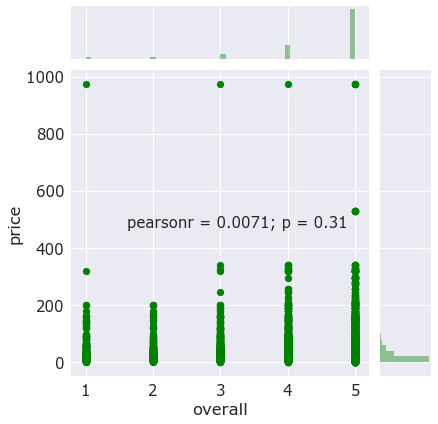

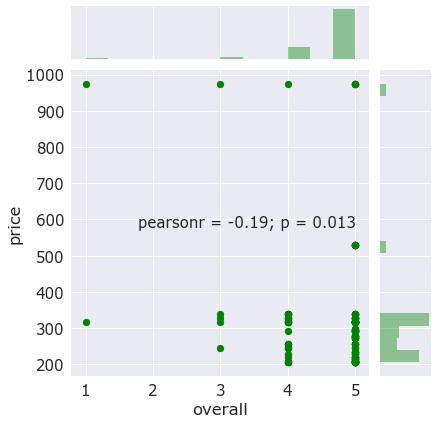

In [38]:
sns.jointplot(final_df.overall, final_df.price, color="green");
price_above = final_df.loc[final_df.price > 200]
sns.jointplot(price_above.overall, price_above.price, color="green");
plt.show()

From the heatmap below, it can be seen that there is no correlation between price and overall satisfaction of each product

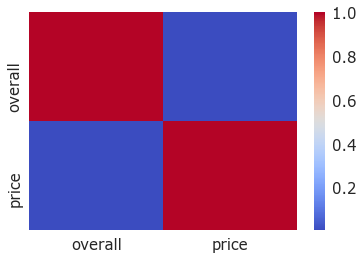

In [39]:
sns.heatmap(final_df.corr(), cmap = 'coolwarm')
plt.show()

Moving on to product brands, what are the most popular ones?

In [40]:
a = final_df.groupby(final_df.brand).overall.mean()
scoring = a.sort_values()
b = final_df.groupby(final_df.brand).overall.count()
overall_scoring = b.sort_values().reset_index()
overall_scoring[:10]

,brand,overall
0,LEXEN,5
1,LedGlow,5
2,MICTUNING,5
3,Brica,5
4,Metro Vacuum,5
5,Monroe,5
6,Motive Products,5
7,Motor Trend,5
8,Blazer International Trailer &amp; Towing Acce...,5
9,OES Genuine,5


What is the average price of the most popular brands?

In [41]:
top_5 = overall_scoring[-5:].values.tolist()
print("Top 5 Most Purchased Brands\n")
all_prices = {}

for i in range(5):
    all_prices[top_5[i][0]] =(final_df.loc[final_df.brand == top_5[i][0]].price.mean())
    print("Rank", 5-i, top_5[i][0], "has average price $", final_df.loc[final_df.brand == top_5[i][0]].price.mean(),"\n")

Top 5 Most Purchased Brands

Rank 5 Chemical Guys has average price $ 15.808368983957173 

Rank 4 Rugged Ridge has average price $ 44.276925133689694 

Rank 3 Battery Tender has average price $ 23.972791461412175 

Rank 2 Camco has average price $ 13.405939849624096 

Rank 1 Meguiar&#39;s has average price $ 15.21194849785417 



In [42]:
top_5_prices = pd.DataFrame.from_dict(all_prices, orient='index') 
top_5_prices=top_5_prices.reset_index(col_fill='brands')
top_5_prices.reset_index(col_fill='brands')

,level_0,index,0
0,0,Chemical Guys,15.808369
1,1,Rugged Ridge,44.276925
2,2,Battery Tender,23.972791
3,3,Camco,13.405940
4,4,Meguiar&#39;s,15.211948


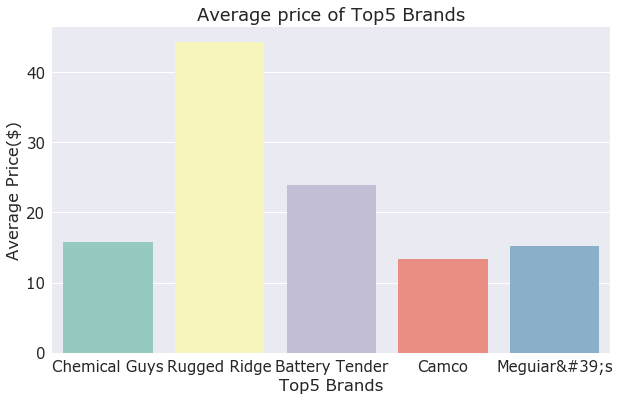

In [43]:
f,ax1 = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x='index', y=0, palette="Set3", data=top_5_prices,ax=ax1)
ax1.set_xlabel("Top5 Brands")
ax1.set_ylabel("Average Price($)")
ax1.set_title('Average price of Top5 Brands')
plt.show()

What about the average ratings for the top brands?

In [44]:
top_5 = overall_scoring[-5:].values.tolist()
print("Top 5 Most Purchased Brands\n")
all_rating = {}

for i in range(5):
    all_rating[top_5[i][0]] =(final_df.loc[final_df.brand == top_5[i][0]].overall.mean())
    print("Rank", 5-i, top_5[i][0], "has average score", final_df.loc[final_df.brand == top_5[i][0]].overall.mean(),"\n")

Top 5 Most Purchased Brands

Rank 5 Chemical Guys has average score 4.459893048128342 

Rank 4 Rugged Ridge has average score 4.518716577540107 

Rank 3 Battery Tender has average score 4.7569786535303775 

Rank 2 Camco has average score 4.413533834586466 

Rank 1 Meguiar&#39;s has average score 4.482403433476395 



In [45]:
top_5_rating = pd.DataFrame.from_dict(all_rating, orient='index') 
top_5_rating=top_5_rating.reset_index()
top_5_rating

,index,0
0,Chemical Guys,4.459893
1,Rugged Ridge,4.518717
2,Battery Tender,4.756979
3,Camco,4.413534
4,Meguiar&#39;s,4.482403


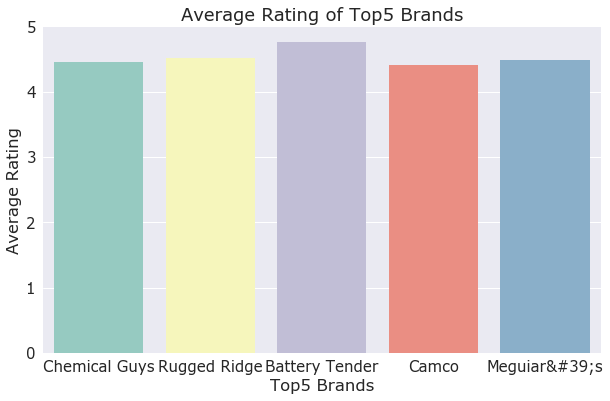

In [46]:
f,ax1 = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(x='index', y=0, palette="Set3", data=top_5_rating,ax=ax1)
ax1.set_xlabel("Top5 Brands")
ax1.set_ylabel("Average Rating")
ax1.set_title('Average Rating of Top5 Brands')
plt.show()

Some extra information extraction

In [47]:
b = final_df.groupby(final_df.brand).overall
c = final_df.groupby(final_df.reviewTime.dt.year).brand.describe()
print(c)
print(c['unique'])

           count unique             top freq
reviewTime                                  
2005           3      3          Innova    1
2006           9      9  Sopus Products    1
2007          37     25   Meguiar&#39;s    4
2008          93     43   Meguiar&#39;s   13
2009         224     78   Meguiar&#39;s   16
2010         442    144  Battery Tender   34
2011        1019    215   Meguiar&#39;s   83
2012        2402    318           Bosch  150
2013        6757    403   Meguiar&#39;s  515
2014        4172    372   Meguiar&#39;s  357
reviewTime
2005      3
2006      9
2007     25
2008     43
2009     78
2010    144
2011    215
2012    318
2013    403
2014    372
Name: unique, dtype: object


More graphing of various attributes

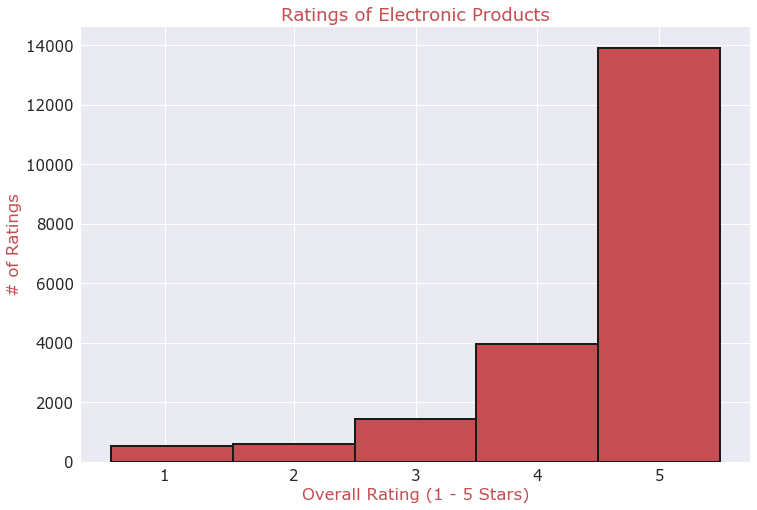

In [48]:
# Graphing overall review ratings
fig, ax = plt.subplots(figsize=(12,8))
g = sns.distplot(df.overall, kde=False, bins=5, color='r', ax=ax, hist_kws=dict(edgecolor="k", linewidth=2, alpha=1))
g.set_xlabel("Overall Rating (1 - 5 Stars)", color='r')
g.set_ylabel("# of Ratings", color='r')
g.set_title("Ratings of Electronic Products", color='r')
g.set_xticks([1.35,2.2,3,3.8,4.6]) # hacky way to center x axis
g.set_xticklabels([1, 2, 3, 4, 5]) # labels for x axis
plt.show()

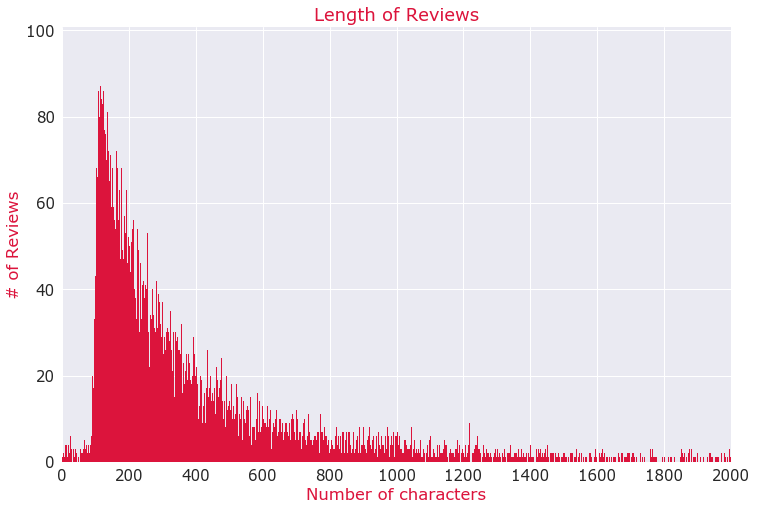

In [49]:
# Number of characters graph
templengthdf = pd.DataFrame()
templengthdf['length'] = df['reviewText'].str.len()
templengthdf['reviewText'] = df['reviewText']
templengthdf = templengthdf.sort_values(['length'])
templengthdf.reset_index(inplace=True)
del templengthdf['index']

sample = 1600000
tempCountdf = pd.DataFrame()
countSeries = templengthdf[:sample].groupby('length') # Select 1.6m reviews
tempCountdf['Count'] = countSeries.count().reviewText
tempCountdf.reset_index(inplace=True)
lengthdf = tempCountdf.sort_values(['length'])
lengthdf.reset_index(inplace=True)
del lengthdf['index']

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(lengthdf.length, lengthdf.Count, color='crimson', width=1.0)
plt.title("Length of Reviews", color='crimson')
plt.xlabel("Number of characters", color='crimson')
plt.ylabel("# of Reviews", color='crimson')
tick_spacing = 200 # x axis moves in intervals of 200
plt.xlim(0,2000)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) # set ticker to specified interval tick
plt.show()

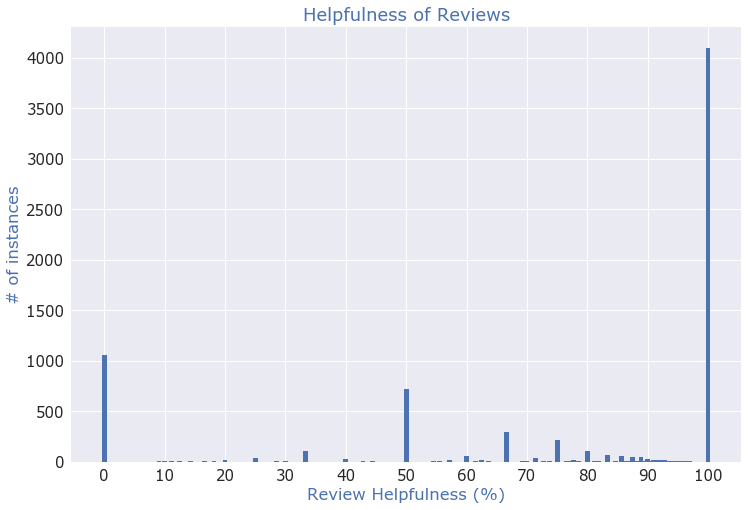

In [50]:
# Split the helpful column list [0,0] into two seperate columns 0 | 0 
dfhelpful = pd.DataFrame()
dfhelpful[['Helpful', 'Total']] = df.helpful.apply(pd.Series)

# Calculate Non-helpful votes on reviews
dfhelpful['Non-helpful'] = dfhelpful['Total'] - dfhelpful['Helpful']
# Calculate % of how helpful a certain review was
dfhelpful['percent'] = (dfhelpful['Helpful'] / dfhelpful['Total']) * 100 
#dfhelpful['percent'].fillna(0, inplace=True)
dftemp = dfhelpful.sort_values(['percent']) # sort percentage values in ascending order
dftemp.reset_index(inplace=True)
del dftemp['index']

w = pd.DataFrame()
q = dftemp.groupby('percent')
w['Count'] = q.count().Helpful
w.reset_index(inplace=True)
dffinal = w.sort_values(['percent'])
dffinal.reset_index(inplace=True)
del dffinal['index']

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(dffinal.percent, dffinal.Count)
plt.title("Helpfulness of Reviews", color='b')
plt.xlabel("Review Helpfulness (%)", color='b')
plt.ylabel("# of instances", color='b')
tick_spacing = 10 # set x axis ticks to be 10 units per increment
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) # apply tick_spacing
plt.show()

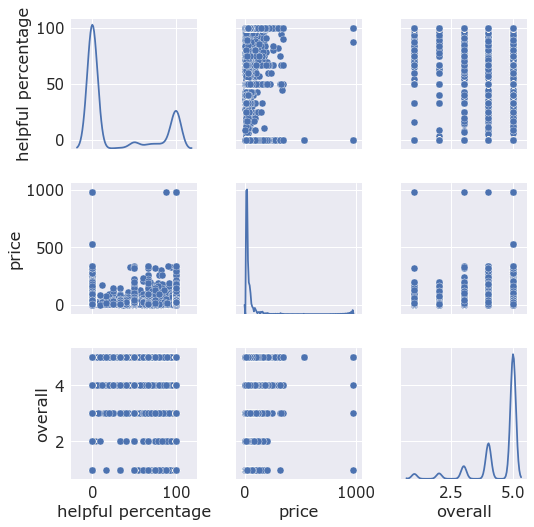

In [51]:
dfhelpful[['price','overall']]=final_df[['price','overall']]
dfhelpful_final = pd.DataFrame()
dfhelpful_final[['helpful percentage','price','overall']]=dfhelpful[['percent','price','overall']]
dfhelpful_final=dfhelpful_final.reset_index()
dfhelpful_final.fillna(0,inplace=True)
sns.pairplot(dfhelpful_final,vars=['helpful percentage','price','overall'],diag_kind="kde")
plt.show()

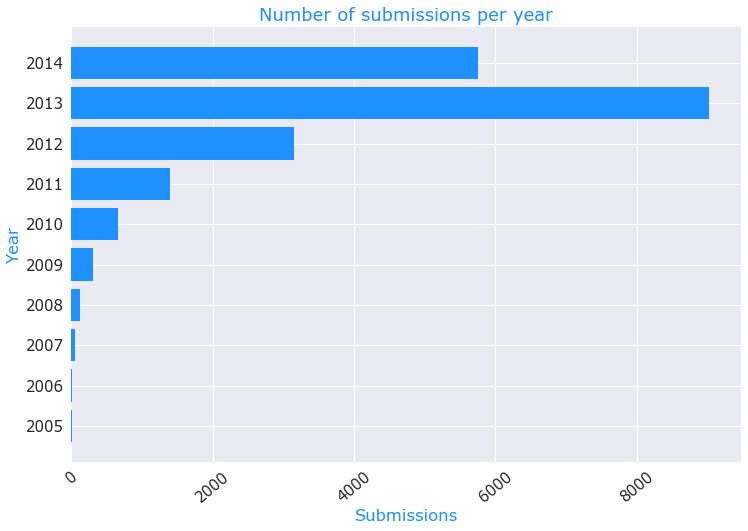

In [52]:
# Yearly submission graph
tempdf = pd.DataFrame()
x = df.groupby('reviewTime') # Group dates
tempdf['Count'] = x.count().asin # Count number of times a date occurs
tempdf.reset_index(inplace=True)
tempdf['reviewTime'] = pd.to_datetime(tempdf['reviewTime']) # Convert to datetime format
tempsubmissiondf = tempdf.sort_values(['reviewTime']) # Sort dates in chronological order
tempsubmissiondf.reset_index(inplace=True) 
del tempsubmissiondf['index']

submissiondf = pd.DataFrame()
x = tempsubmissiondf.groupby(tempsubmissiondf.reviewTime.dt.year)
submissiondf['submissions'] = x.sum().Count
years = ['2005','2006','2007','2008','2009','2010','2011','2012','2013','2014']
submissiondf['reviewTime'] = years

fig, ax = plt.subplots(figsize=(12,8))
plt.barh(submissiondf.reviewTime, submissiondf.submissions, align='center', color='dodgerblue')
plt.xticks(rotation=40) # rotate the x axis labels
plt.title("Number of submissions per year", color='dodgerblue')
plt.xlabel("Submissions", color='dodgerblue')
plt.ylabel("Year", color='dodgerblue')
plt.show()

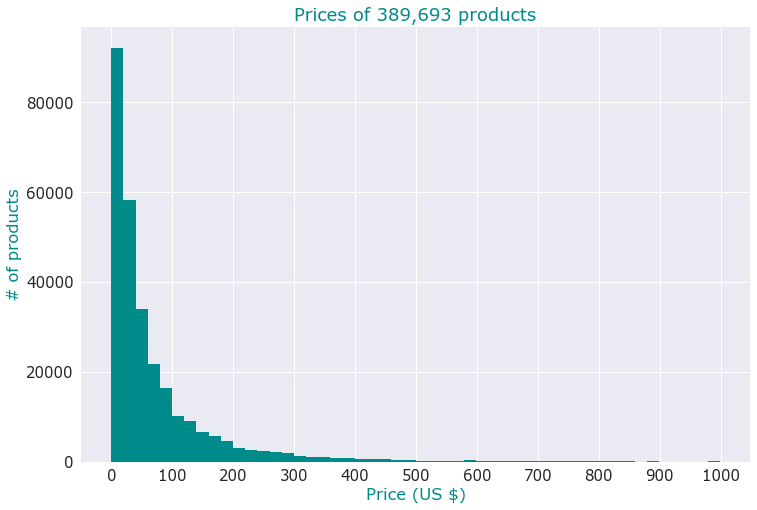

In [53]:
# Product Price graph
pricedf = pd.DataFrame()
pricedf['price'] = productdf['price']
pricedf.price.fillna(0)
pricedf['price'] = pd.to_numeric(pricedf['price'], errors='coerce')
pricedf = pricedf.dropna(subset=['price'])
pricedf['price'] = pricedf['price'].astype(int)

fig, ax = plt.subplots(figsize=(12,8))
sns.distplot(pricedf.price, kde=False, hist_kws=dict(alpha=1), color='darkcyan')
plt.title("Prices of 389,693 products", color='darkcyan')
plt.xlabel("Price (US $)", color='darkcyan')
plt.ylabel("# of products", color='darkcyan')
tick_spacing = 100 
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

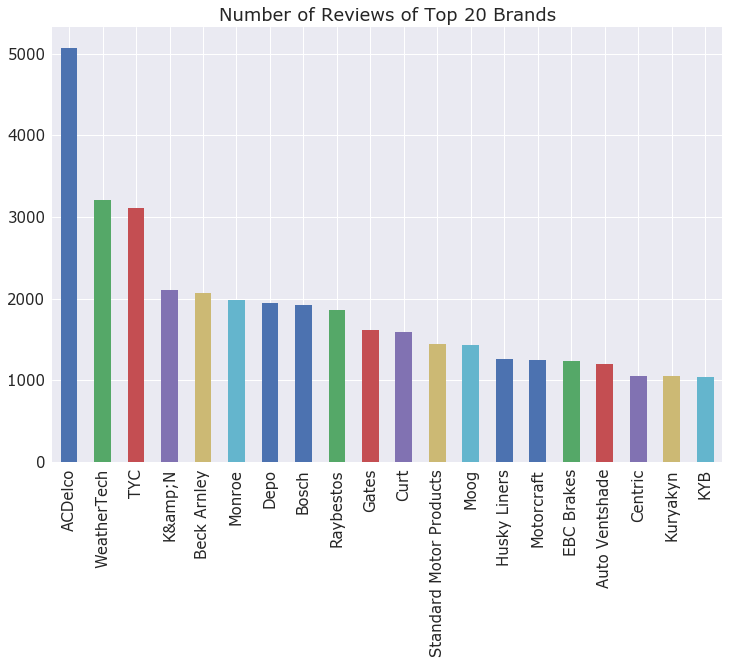

In [54]:
brands = productdf["brand"].value_counts()
plt.figure(figsize=(12,8))
b=brands[1:21].plot(kind='bar')
plt.title("Number of Reviews of Top 20 Brands")
plt.show(b)

In [55]:
df['helpful_%'] = np.where(dfhelpful['Total'] > 0, dfhelpful['Helpful'] / dfhelpful['Total'], -1)
df['upvote_%'] = pd.cut(df['helpful_%'], labels = ['Unknown', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], include_lowest = True)

Text(0.5,46,'Rating')

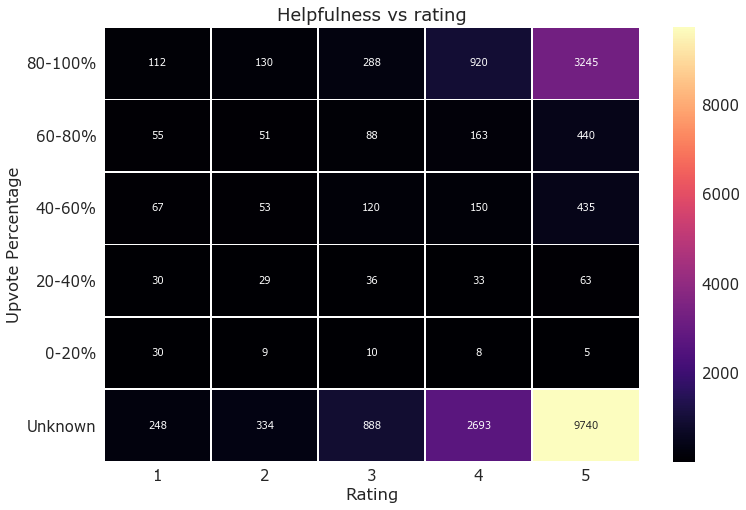

In [56]:
fig = plt.figure(figsize=(12,8))
dfmap = df.groupby(['overall', 'upvote_%']).agg({'reviewerID': 'count'})
dfmap = dfmap.unstack()
dfmap.columns = dfmap.columns.get_level_values(1)
s=sns.heatmap(dfmap[dfmap.columns[::-1]].T, cmap = 'magma', fmt = 'd', linewidths=.7, annot = True)
plt.yticks(rotation=0)
plt.title('Helpfulness vs rating')
plt.ylabel("Upvote Percentage")
plt.xlabel("Rating")

Text(0,0.5,'Words in review')

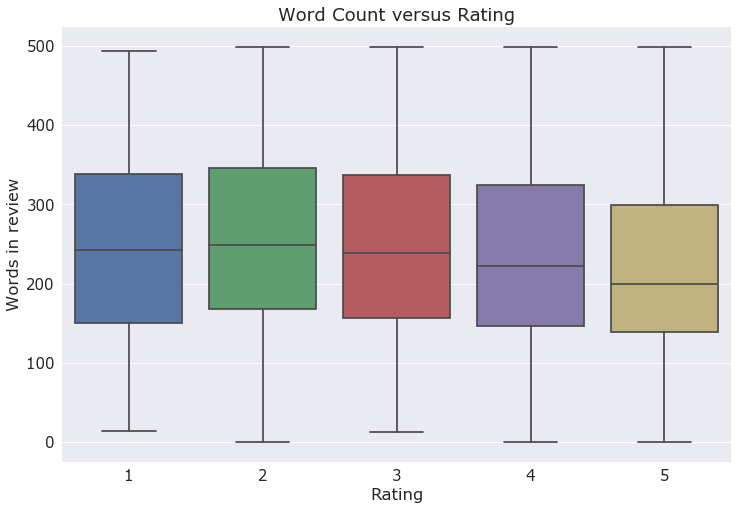

In [57]:
fig = plt.subplots(figsize=(12,8))
df['textLength'] = df["reviewText"].dropna().map(lambda x: len(x))
review_Length_Under = df[df.textLength < 500] # select all instances under 500 words
sns.boxplot(review_Length_Under.overall, review_Length_Under.textLength)
plt.title("Word Count versus Rating")
plt.xlabel("Rating")
plt.ylabel("Words in review")
# 5 star reviews have lowest median word count of approx. 200 words

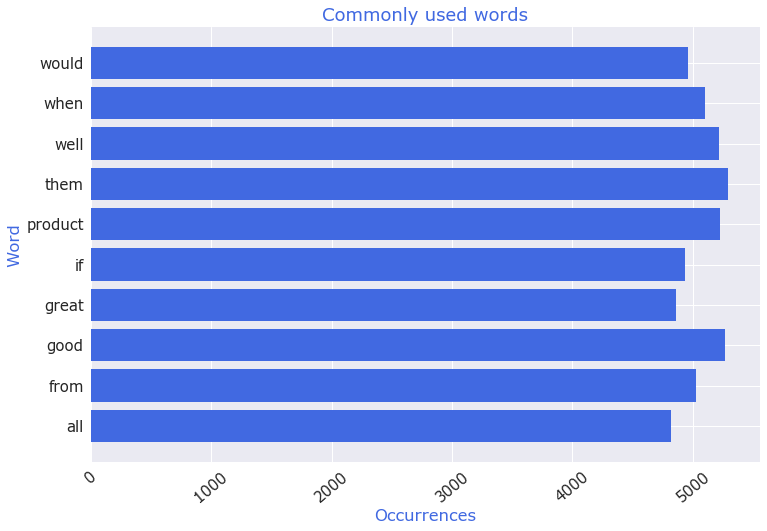

In [58]:
#nltk.download()
store_words = []
for i in df.reviewText:
    line = nltk.word_tokenize(i)
    for j in line:
        store_words.append(j)
feat = nltk.FreqDist(store_words)
word_list = pd.DataFrame(feat.most_common(100),columns=['word','total'])
fin = word_list[50:60]
fin = fin.sort_values(['total'])
fig, ax = plt.subplots(figsize=(12,8))
plt.barh(fin.word, fin.total, align='center', color='royalblue')
plt.xticks(rotation=40)
plt.xlabel('Occurrences', color='royalblue')
plt.ylabel('Word', color='royalblue')
plt.title('Commonly used words', color='royalblue')
plt.show()

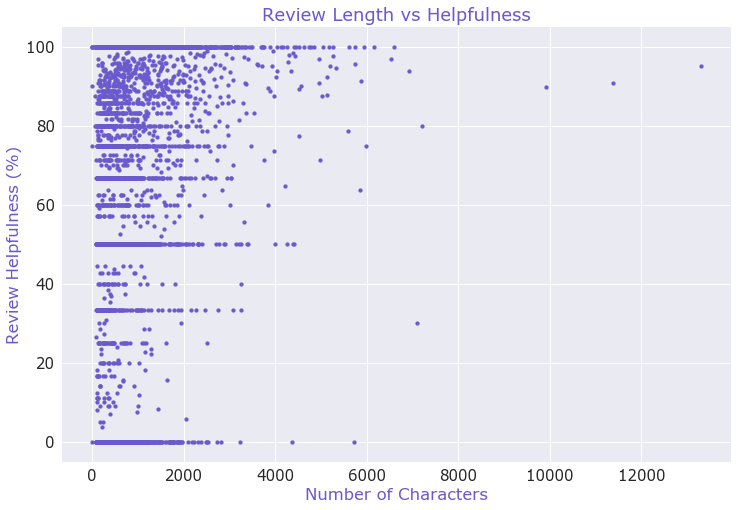

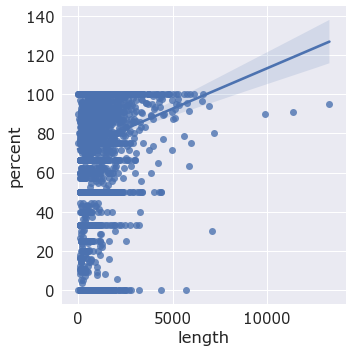

In [59]:
lengthHelpful = pd.DataFrame()
lengthHelpful['length'] = df['reviewText'].str.len()
lengthHelpful[['percent']] = dfhelpful[['percent']]
fig = plt.subplots(figsize=(12,8))
plt.scatter(lengthHelpful.length, dfhelpful.percent,  color='slateblue', s=15)
plt.ylabel('Review Helpfulness (%)', color='slateblue')
plt.xlabel('Number of Characters', color='slateblue')
plt.title('Review Length vs Helpfulness', color='slateblue')
sns.lmplot(x='length', y='percent', truncate=True, size=5,data=lengthHelpful)
plt.show()

# Lexicon Approach

In [60]:
ndf = final_df
ndf.dropna(subset=['price'], inplace=True)
new_df_5 = ndf.reviewText.loc[ndf.overall==5]
new_df_4 = ndf.reviewText.loc[ndf.overall==4]
new_df_3 = ndf.reviewText.loc[ndf.overall==3]
new_df_2 = ndf.reviewText.loc[ndf.overall==2]
new_df_1 = ndf.reviewText.loc[ndf.overall==1]
new_df_1.head()

#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
def lex_percentage_good(df):
    good_count = 0
    total = 0
    for doc in df:
        ss = sid.polarity_scores(doc)
        total+=1
        if ss["compound"] > 0:
            good_count+=1
    print(good_count * 100 // total,"%")
    return good_count * 100 // total

positive_vals = {}
a = lex_percentage_good(new_df_5)
b = lex_percentage_good(new_df_4)
c = lex_percentage_good(new_df_3)
d = lex_percentage_good(new_df_2)
e = lex_percentage_good(new_df_1)

87 %
85 %
74 %
65 %
50 %


Text(0.5,1,'Lexicon Positive Review Sorting')

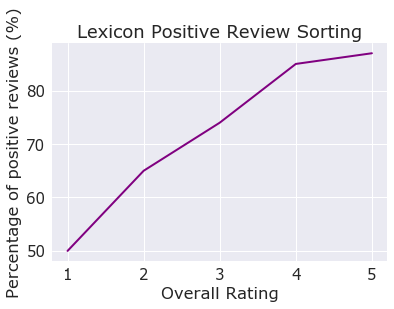

In [61]:
positive_vals[5] = a
positive_vals[4] = b
positive_vals[3] = c
positive_vals[2] = d
positive_vals[1] = e

plottingdf = pd.DataFrame.from_dict(positive_vals, orient='index')
plt.plot(plottingdf,'-', linewidth=2, c='purple')
plt.xlabel('Overall Rating')
plt.ylabel('Percentage of positive reviews (%)')
plt.title('Lexicon Positive Review Sorting')

# Word Clouds - Classifying Positive/Negative reviews

Neutral reviews are going to be included into negative reviews 
Assuming Negative reviews are 1-3 stars and positive are 4-5 stars a column can be created to illistrate
a negative or positive review (0 = negative, 1 = positive)

In [62]:
df['pos_or_neg'] = [1 if x > 3 else 0 for x in df.overall]

In [63]:
df.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,helpful_%,upvote_%,textLength,pos_or_neg
1464,B0002U2V1Y,"[134, 172]",5,After reading numerous raving reviews here at ...,2005-07-15,A1VQHH85U7PX0,"MyBeesWax ""A Music Fan""",Wwww...wow!!!,0.779070,60-80%,1924,1
7647,B000KL0HX4,"[80, 82]",4,The battery croaked after 5 years. I just boug...,2005-10-23,A10ZFE6YE0UHW8,C. MacPhail,Perfect for Tires - Nicely Designed,0.975610,80-100%,1551,1
6719,B000EVWDAK,"[11, 18]",5,"Went to the dealer because the ""Check Engine"" ...",2005-12-01,A28K7LCY4GNITJ,R. SAFRENO,A little late to buy,0.611111,60-80%,205,1
9138,B000WNED08,"[53, 59]",5,"This stuff is the best example I can think of,...",2006-03-04,AW7BIYHXUIZ62,T.M. Reader,Miracle in a bottle,0.898305,80-100%,1123,1
4033,B000AMLWH8,"[0, 0]",5,Great for interior leather and plastics except...,2006-05-08,ARBKYIVNYWK3C,RST10,Perfect for getting rid of dust and protecting...,-1.000000,Unknown,348,1


Average Score:  4.471840961266058
Median Score:  5.0


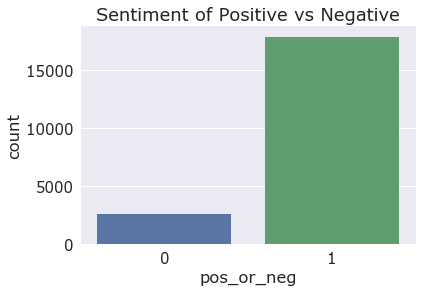

In [64]:
print("Average Score: ",np.mean(df.overall))
print("Median Score: ",np.median(df.overall))
plt.xlabel('0=Neg 1=Pos')
plt.title('Sentiment of Positive vs Negative')
plt.show(sns.countplot(df.pos_or_neg))

In [65]:
print("Positive reviews: {:.2f}%".format(len(df[df.pos_or_neg==1])/len(df)*100))
print("Negative reviews: {:.2f}%".format(len(df[df.pos_or_neg==0])/len(df)*100))

Positive reviews: 87.41%
Negative reviews: 12.59%


Create a dictionary of words that is sorted into positive/negative parts. Words generally found in positive reviews are put into the positive dictionary, words found in negative reviews are put into the negative dictionary 

In [66]:
data_label = df.pos_or_neg.values
data_review = df.reviewText.values
positive = [data_review[i] for i in range(len(data_review)) if data_label[i] == 1]
negative = [data_review[i] for i in range(len(data_review)) if data_label[i] == 0]

# counter is used for faster counting
positive_counter = Counter()
negative_counter = Counter()
total_counter = Counter()
score = Counter()

for i in data_review:
    total_counter.update(i.split(" "))
for i in positive:
    positive_counter.update(i.split(" "))
print("Word list positive = {}".format(len(positive_counter.keys())))
for i in negative:
    negative_counter.update(i.split(" "))
print("Word list negative = {}".format(len(negative_counter.keys())))

total_list = (set(positive_counter.keys())).intersection(set(negative_counter.keys()))
for i in total_list: 
    if total_counter[i] > 100:
        current_score = positive_counter[i] / float(negative_counter[i] + 1)
        if current_score < 1:
            score[i] = -np.log(1/(current_score+0.01)) 
        else:
            score[i] = np.log(current_score)

Word list positive = 76455
Word list negative = 27361


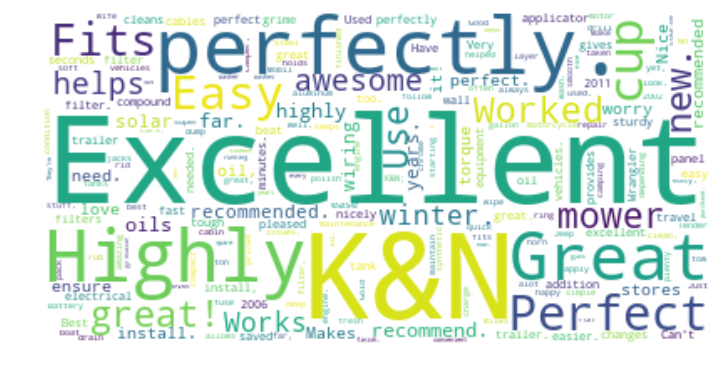

In [67]:
pos_dictionary = {} # based on lecture slides
for i, j in score.items():
    if (j > 1): 
        pos_dictionary[i] = j
plt.figure(figsize=(12,8))
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=pos_dictionary)
plt.imshow(wordcloud, interpolation="bilinear") # display image on axis
plt.axis("off") # important so it doesnt display it like a grid
plt.show(wordcloud)

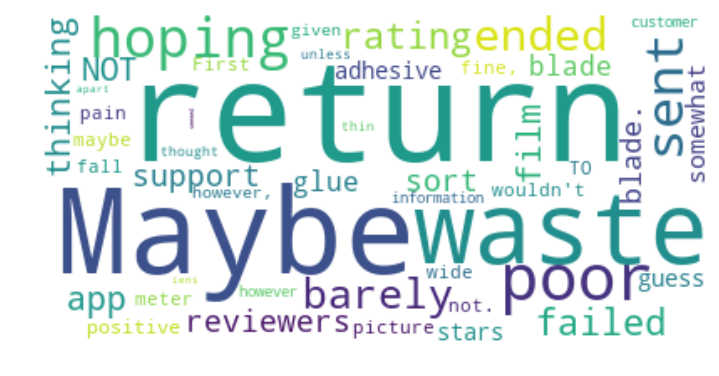

In [68]:
neg_dictionary = {}
for i, j in score.items():
    if (j < 1) & (j > 0): 
        neg_dictionary[i] = -np.log(j)
wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=neg_dictionary)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show(wordcloud)

# Predicitions

Making predicitions/forecasting with seasonality

In [69]:
prediction_data  = final_df.groupby([final_df.reviewTime.dt.month]).mean()
prediction_data.reset_index(inplace=True)

In [70]:
def convert_seasons(row):
    if row['reviewTime'] >= 1 and row['reviewTime'] <= 4:
        return '1'
    elif row['reviewTime'] >= 5 and row['reviewTime'] <= 8:
        return '2'
    elif row['reviewTime'] >= 9 and row['reviewTime'] <= 12:
        return '3'
def seq(row):
    return row['reviewTime']%4 and row['reviewTime']%4 or 4

In [71]:
def predict_with_seasonality(df, months):
    predict_copy = df.copy()
    predict_copy['Season'] = predict_copy.apply(convert_seasons, axis=1)
    predict_copy['Seq'] = predict_copy.apply(seq, axis=1)
    season_df = pd.DataFrame((predict_copy.pivot('Seq','Season')['price']).to_records())
    season_df.index = season_df['Seq']
    season_df = season_df.drop(['Seq'], axis=1)
    averagedf = season_df.apply(np.mean)
    indexingdf = pd.DataFrame(columns=['1','2','3'])
    indexingdf['1'] = season_df['1']/averagedf['1']
    indexingdf['2'] = season_df['2']/averagedf['2']
    indexingdf['3'] = season_df['3']/averagedf['3']
    indexingdf['Avg'] = indexingdf.mean(axis=1)
    season = np.array([1,2,3])
    avg_arr = np.array([averagedf['1'], averagedf['2'], averagedf['3']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    forecast_df = pd.DataFrame(columns=['Month','price'])
    forecast_df['price'] = indexingdf['Avg'] * average_predict
    forecast_df['Month'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

C:\Users\soap_\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RankWarning: Polyfit may be poorly conditioned
  app.launch_new_instance()


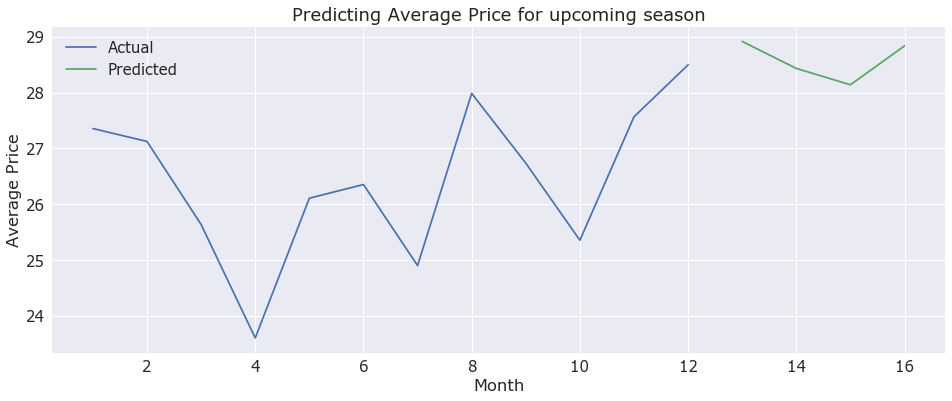

In [73]:
season_df = predict_with_seasonality(prediction_data, [13,14,15,16])
f, ax = plt.subplots(figsize=(16,6))
plt.plot(prediction_data['reviewTime'], prediction_data['price'], label='Actual')
plt.plot(season_df['Month'], season_df['price'], label='Predicted')
tick_spacing = 2 
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) 
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.title("Predicting Average Price for upcoming season")
plt.legend()

Predicitions/Forecasting made without seasonality

Moving Average (k=3)

In [76]:
moving_average = pd.DataFrame(columns=['reviewTime','price'])
for i in range(0, 16):
    if i > 3:
        history = prediction_data['price'][i-3:i]
        predict = history.mean()
    else:
        predict = float('nan')
    moving_average.loc[i] = [i + 1, predict]

ma_df = moving_average

Exponential Smoothing

In [78]:
def exponential_smoothing(df, a):
    esmoothing_df = pd.DataFrame(columns=['reviewTime','price'])
    esmoothing_df.loc[0] = [1, df['price'][0]]
    num_df = len(df)
    for i in range(0, num_df):
        predict = a * df['price'][i] + (1-a) * esmoothing_df['price'][i]
        esmoothing_df.loc[i+1] = [i + 2, predict]
    esmoothing_df['reviewTime'] = esmoothing_df['reviewTime'].astype(int)
    return esmoothing_df
exp_smooth_1 = exponential_smoothing(prediction_data, 0.1)
exp_smooth_2 = exponential_smoothing(prediction_data, 0.5)
exp_smooth_3 = exponential_smoothing(prediction_data, 1.0)

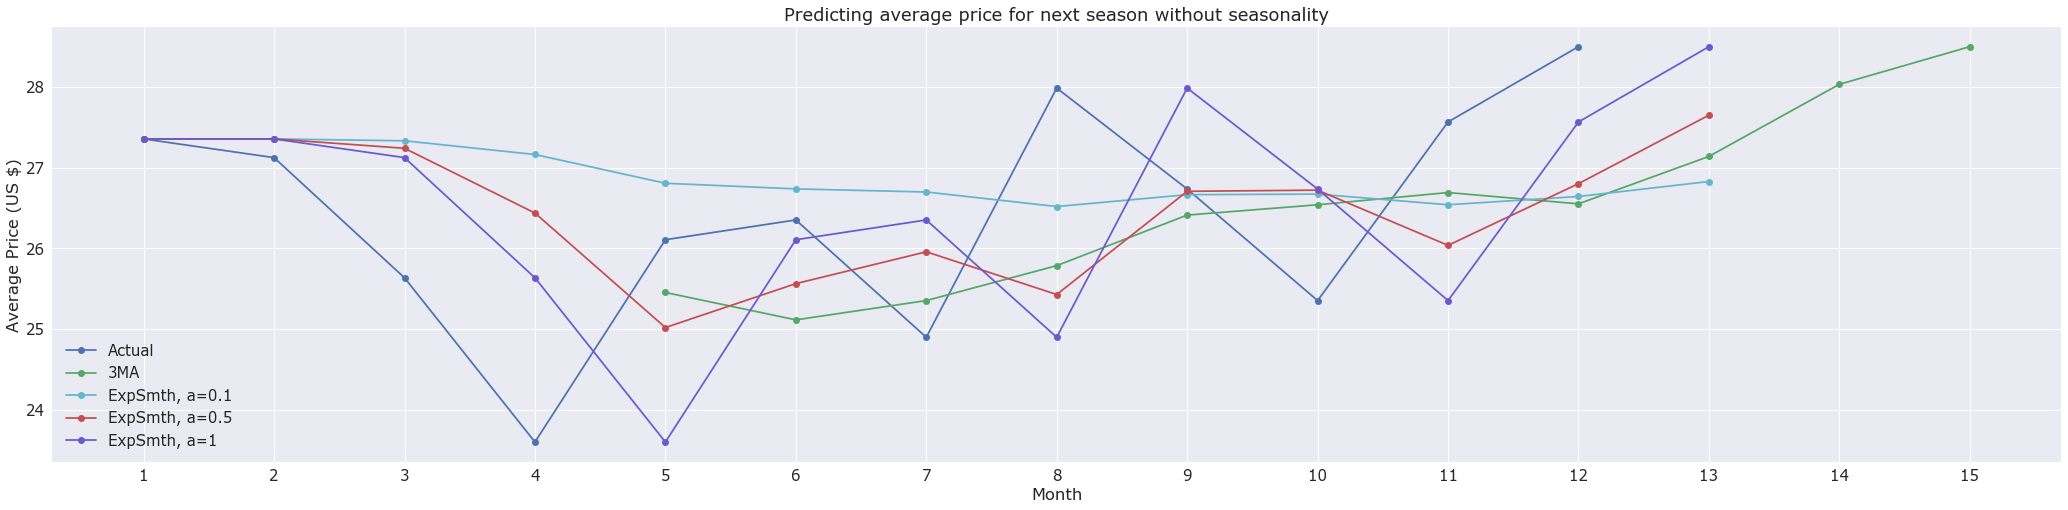

In [80]:
f, ax = plt.subplots(figsize=(36, 8))
plt.plot(prediction_data.reviewTime, prediction_data.price,  color='b', label='Actual', marker='o')
plt.plot(ma_df.reviewTime, ma_df.price, color='g', label='3MA', marker='o')
plt.plot(exp_smooth_1.reviewTime, exp_smooth_1.price, color='c', label='ExpSmth, a=0.1', marker='o')
plt.plot(exp_smooth_2.reviewTime, exp_smooth_2.price, color='r', label='ExpSmth, a=0.5', marker='o')
plt.plot(exp_smooth_3.reviewTime, exp_smooth_3.price, color='slateblue', label='ExpSmth, a=1', marker='o')
plt.xlabel("Month")
plt.ylabel("Average Price (US $)")
plt.title("Predicting average price for next season without seasonality")
tick_spacing = 1
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing)) 
plt.legend()

# Miscellaneous

This section contains functions that weren't used for the analysis proccess, but are useful in some way.

Clean review text of all the garbage

In [81]:
# Remove all non charcters, convert to all lowercase, optional parameter to remove stopwords (and, i, etc)
def clean_review(review_text, remove_stopwords=False):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)  # non character removal
    words = letters_only.lower().split() # lower case conversion
    if remove_stopwords: 
        stops = set(stopwords.words("english"))
        words = [i for i in words if not i in stops]
    return( " ".join(words))

In [82]:
cleaned_reviews = []
for i in df.reviewText:
    cleaned_reviews.append(clean_review(i))

In [83]:
cleaned_reviews[10]

'you can trust that this item works well and does not scratch your paint i was always skeptical previously and just asssumed these things scratched the car but my paintless dent removal guy uses one and highly recommended the california duster to me he is fanatical about keeping his car totally detailed and this product works so well that he never even washes his car unless it gets rained on he just dusts it every morning before he backs out of his garage and if needed he uses some liquid instant detailer and a microfiber cloth after dusting if he feels like it it takes a total of less than minutes to dust off an entire car yet the result makes your car look like you just washed it i use the california duster before putting on my car cover so that there is no dust between the car and car cover if you have a garage it s quite useful since dust settles on the car during the day when you are out and about and at night even garaged you won t have to wash your car as often if you use the ca

Count word function

In [84]:
def word_count(counting_dictionary, raw_text):
    for i in raw_text:
        for word in i.split():
            if word not in counting_dictionary:
                counting_dictionary[word] = 1
            else:
                counting_dictionary[word] += 1

In [85]:
word_counts = {}
word_count(word_counts, cleaned_reviews) # use all the cleaned reviews
print("Number of unique words:", len(word_counts))

Number of unique words: 25038


In [86]:
# How many times have people said "good"
word_counts["good"]

5905

In [87]:
# How many times have people said "bad"
word_counts["bad"]

773